# 도로 크랙 이미지 분류
- EfficientNet pre-trained model 사용
- binary classification

# 결과
- 분류 실패
- 데이터 증강 또는 더 나은 모델 필요

---

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import RMSprop

#### Preparing Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/IN-ISP/RoadCrack.zip

In [ ]:
train_dir = '/content/RoadCrack/train'
valid_dir = '/content/RoadCrack/valid'
test_dir = '/content/RoadCrack/test'

In [ ]:
# Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
# train_datagen = ImageDataGenerator(rescale = 1./255)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=30,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=30,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=30,
    class_mode='binary')

Found 896 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


#### Model

In [ ]:
train_generator[0][0].shape

(30, 224, 224, 3)

In [ ]:
# EfficientNet pretrained model
pretrained_model = EfficientNetB0(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

In [ ]:
# fully connected layer 추가
x = pretrained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs = pretrained_model.input, outputs=predictions)

#### Compile

In [ ]:
model.compile(
    optimizer=RMSprop(learning_rate=0.0001), # adam
    loss='binary_crossentropy',
    metrics = ['accuracy'])

In [ ]:
model.summary()

#### Callback

In [ ]:
ckpt_path = 'roadcrack.ckpt'

ckpt_callback = callbacks.ModelCheckpoint(
    filepath=ckpt_path,
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True,
    verbose=1)

In [ ]:
es_callback = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1)

#### Training

In [ ]:
%%time

EPOCHS = 30
BATCH_SIZE = 30

log = model.fit(
    train_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data = valid_generator,
    callbacks=[ckpt_callback, es_callback],
    verbose=1)

Epoch 1/30


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


30/30 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7612
Epoch 1: val_loss improved from inf to 0.69268, saving model to roadcrack.ckpt
30/30 [==============================] - 52s 2s/step - loss: 0.5350 - accuracy: 0.7612 - val_loss: 0.6927 - val_accuracy: 0.5367
Epoch 2/30
30/30 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8482
Epoch 2: val_loss did not improve from 0.69268
30/30 [==============================] - 50s 2s/step - loss: 0.3627 - accuracy: 0.8482 - val_loss: 0.7120 - val_accuracy: 0.5000
Epoch 3/30
30/30 [==============================] - ETA: 0s - loss: 0.2623 - accuracy: 0.8962
Epoch 3: val_loss did not improve from 0.69268
30/30 [==============================] - 50s 2s/step - loss: 0.2623 - accuracy: 0.8962 - val_loss: 0.7096 - val_accuracy: 0.5000
Epoch 4/30
30/30 [==============================] - ETA: 0s - loss: 0.1991 - accuracy: 0.9241
Epoch 4: val_loss did not improve from 0.69268
30/30 [=====================

#### Training Results

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'],label = 'Val Accuracy')

    plt.legend()
    plt.show()

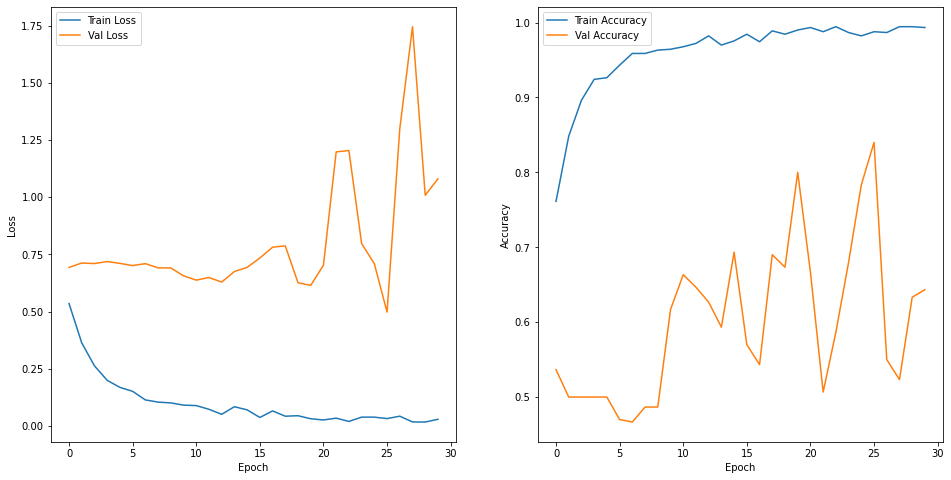

In [ ]:
plot_history(log)

In [ ]:
# best parameter update
model.load_weights(ckpt_path)

#### Evalutation

In [ ]:
train_loss, train_accuracy = model.evaluate(train_generator)

30/30 [==============================] - 35s 1s/step - loss: 0.9845 - accuracy: 0.7545


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)

#### Confusion Matrix

In [ ]:
test_steps = test_generator.n // test_generator.batch_size
y_pred = model.predict(test_generator, steps=test_steps)

In [ ]:
# predict
y_pred_binary = np.argmax(y_pred, axis=1)

In [ ]:
# actual
y_true = test_generator.classes

In [ ]:
cfm = confusion_matrix(y_true, y_pred_binary)

array([[150,   0],
       [150,   0]])

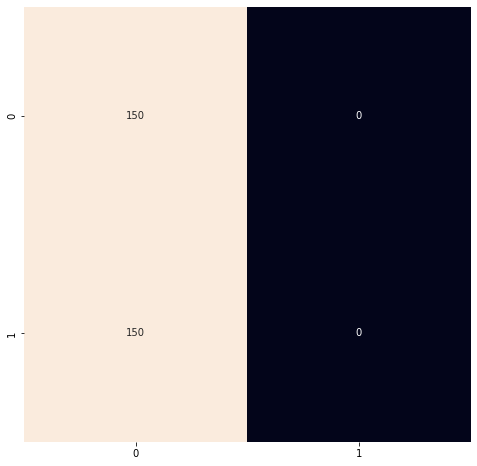

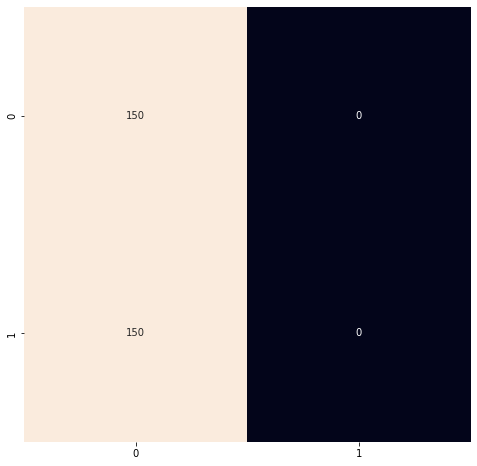

In [ ]:
plt.figure(figsize=(8, 8))
sns.heatmap(cfm, annot=True, cbar=False, fmt='d')
plt.show()